In [109]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
#https://www.kaggle.com/datasets/gauravduttakiit/coffee-leaf-diseases?select=test

In [110]:
BATCH_SIZE = 32
IMAGE_SIZEx = 256
IMAGE_SIZEy=256
CHANNELS=3
EPOCHS=50

In [111]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZEx,IMAGE_SIZEy),
    batch_size=BATCH_SIZE
)


Found 1264 files belonging to 4 classes.


In [112]:
class_names = dataset.class_names
class_names

['miner', 'nodisease', 'phoma', 'rust']

In [113]:
len(dataset)

40

In [114]:
train_size = 0.8
len(dataset)*train_size

32.0

In [115]:
train_ds = dataset.take(13)
len(train_ds)

13

In [116]:
test_ds = dataset.skip(13)
len(test_ds)

27

In [117]:
val_size=0.1
len(dataset)*val_size

4.0

In [118]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [119]:
test_ds = test_ds.skip(1)
len(test_ds)

26

In [120]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [121]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [122]:
len(train_ds)

32

In [123]:
len(val_ds)

4

In [124]:
len(test_ds)

4

In [125]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [126]:
from tensorflow.keras import models, layers
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZEx, IMAGE_SIZEy),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [127]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [128]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [129]:
import tensorflow as tf
from tensorflow.keras import models, layers
CHANNELS = 3

input_shape = (BATCH_SIZE, IMAGE_SIZEx, IMAGE_SIZEy, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [130]:
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

In [131]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [132]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/50
32/32 [==============================] - 107s 2s/step - loss: 1.3803 - accuracy: 0.3115 - val_loss: 1.3622 - val_accuracy: 0.3125
Epoch 2/50
32/32 [==============================] - 58s 2s/step - loss: 1.3314 - accuracy: 0.3661 - val_loss: 1.3035 - val_accuracy: 0.3906
Epoch 3/50
32/32 [==============================] - 57s 2s/step - loss: 1.2245 - accuracy: 0.4246 - val_loss: 1.1054 - val_accuracy: 0.4688
Epoch 4/50
32/32 [==============================] - 57s 2s/step - loss: 1.0398 - accuracy: 0.5268 - val_loss: 0.9234 - val_accuracy: 0.6016
Epoch 5/50
32/32 [==============================] - 57s 2s/step - loss: 0.9336 - accuracy: 0.6042 - val_loss: 0.9463 - val_accuracy: 0.5391
Epoch 6/50
32/32 [==============================] - 57s 2s/step - loss: 0.8042 - accuracy: 0.6448 - val_loss: 0.9151 - val_accuracy: 0.5859
Epoch 7/50
32/32 [==============================] - 58s 2s/step - loss: 0.7928 - accuracy: 0.6528 - val_loss: 0.7632 - val_accuracy: 0.6875
Epoch 8/50
32/32 [=

In [133]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 5s 400ms/step - loss: 0.0215 - accuracy: 0.9922


In [134]:
scores


[0.02145543321967125, 0.9921875]

In [135]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 32}

In [136]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [137]:
type(history.history['loss'])


list

In [138]:
len(history.history['accuracy'])


34

In [139]:
history.history['val_accuracy']

[0.3125,
 0.390625,
 0.46875,
 0.6015625,
 0.5390625,
 0.5859375,
 0.6875,
 0.7578125,
 0.8671875,
 0.9140625,
 0.703125,
 0.8828125,
 0.9609375,
 0.8984375,
 0.8203125,
 0.9453125,
 0.9375,
 0.96875,
 0.9765625,
 0.9609375,
 0.953125,
 0.9609375,
 0.9296875,
 0.9375,
 1.0,
 0.9765625,
 0.9765625,
 0.9609375,
 0.984375,
 0.96875,
 0.9765625,
 0.9453125,
 0.9609375,
 0.984375]

In [140]:
history.history['loss'][:5]

[1.3803294897079468,
 1.3314452171325684,
 1.2244725227355957,
 1.039819598197937,
 0.9335848093032837]

In [141]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


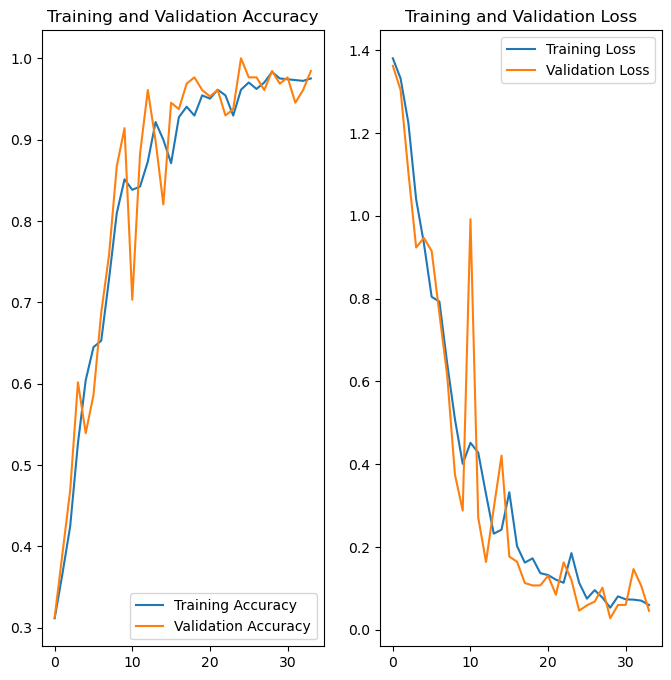

In [144]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(34), acc, label='Training Accuracy')
plt.plot(range(34), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(34), loss, label='Training Loss')
plt.plot(range(34), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


first image to predict
actual label: phoma
1/1 [==============================] - 0s 451ms/step
predicted label: phoma


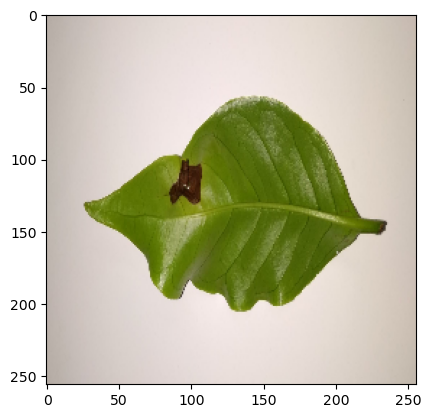

In [145]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [146]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 32ms/step


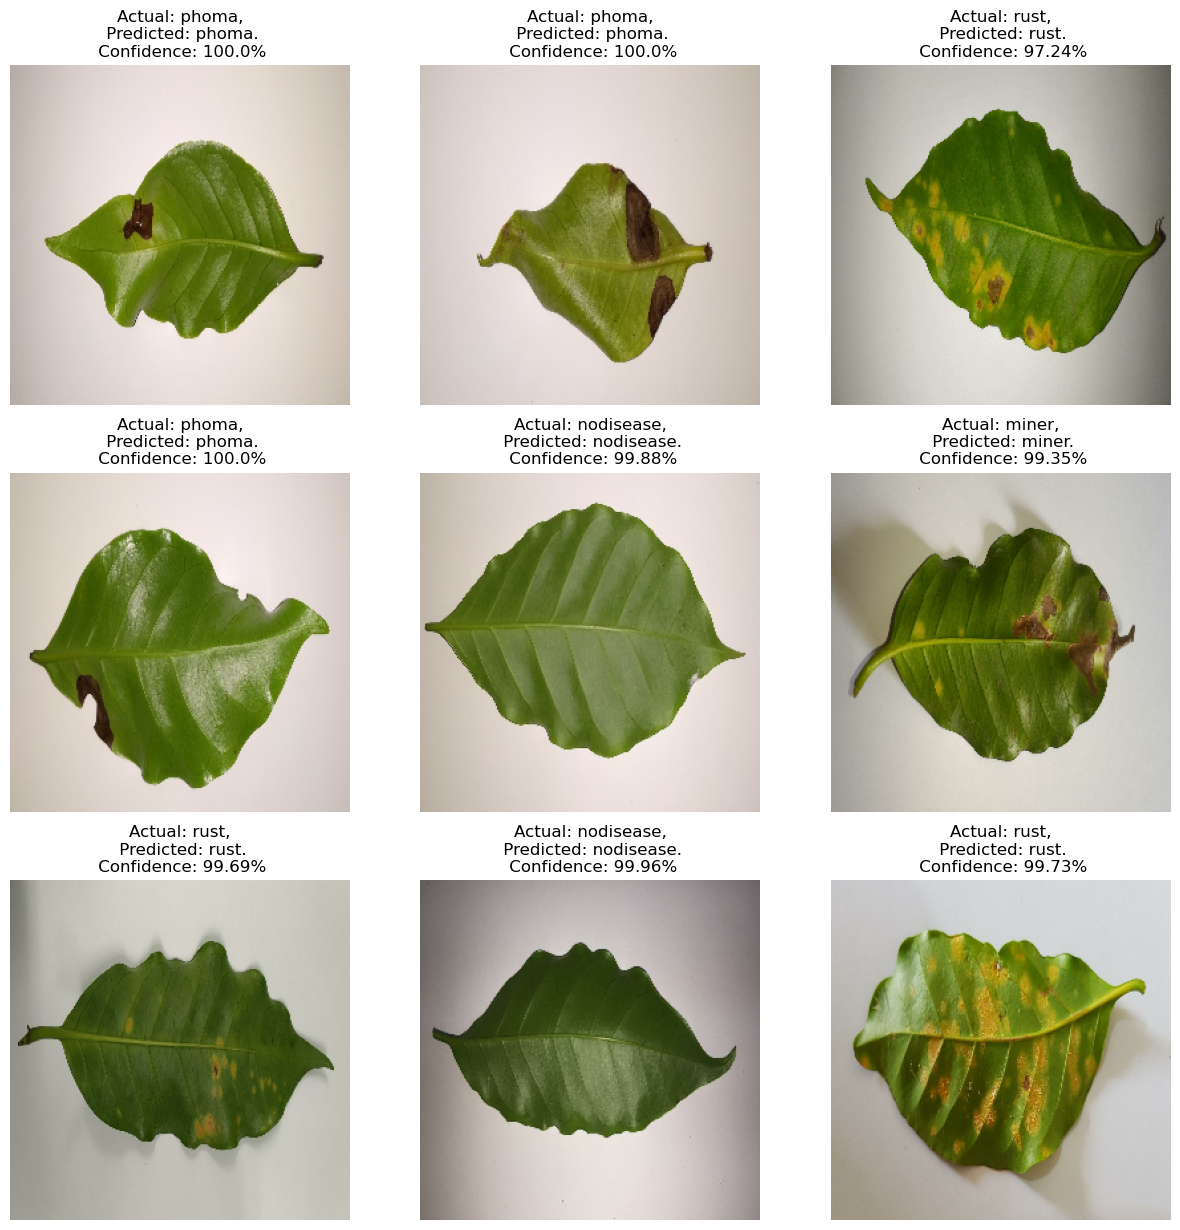

In [147]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [149]:
model_version = 20
model.save(r"C:\Users\frede\agricultura\model\20")

INFO:tensorflow:Assets written to: C:\Users\frede\agricultura\model\20\assets


INFO:tensorflow:Assets written to: C:\Users\frede\agricultura\model\20\assets
